In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [10]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


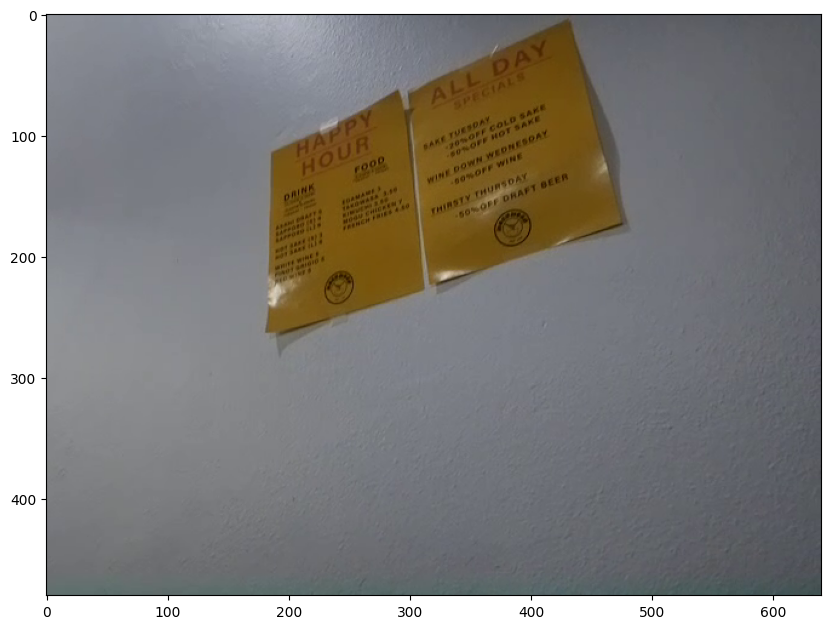

In [11]:
image = cv2.imread('images/restraunt/frame_0014.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [12]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

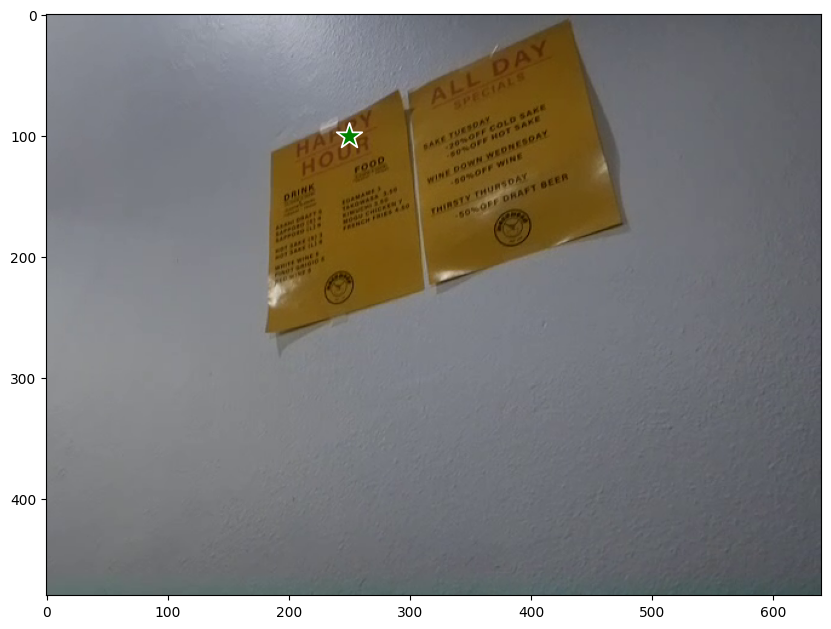

In [13]:
input_point = np.array([[250, 100]])
input_label = np.array([1])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [14]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

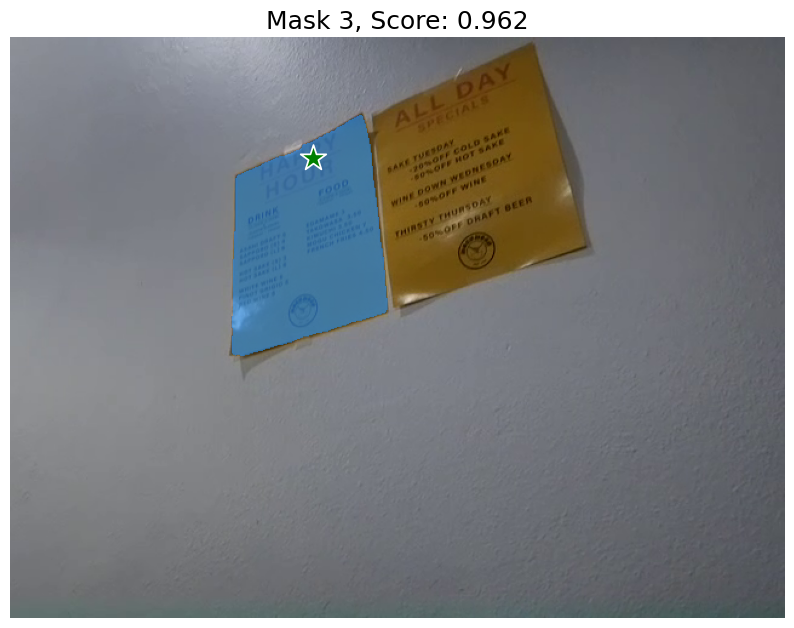

In [15]:
best_mask = None
best_score = 0
for i, (mask, score) in enumerate(zip(masks, scores)):
    if score > best_score:
        best_mask = mask
        best_score = score
    
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(best_mask, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.title(f"Mask {i+1}, Score: {best_score:.3f}", fontsize=18)
plt.axis('off')
plt.show()  
  

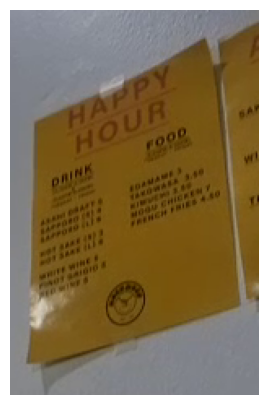

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert the mask to uint8 format
mask_uint8 = (best_mask * 255).astype(np.uint8)

# Find contours in the mask
contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Image dimensions
img_height, img_width = image.shape[:2]

for contour in contours:
    # Compute the bounding box for the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Calculate padding (10% of the bounding box size)
    pad_w = int(0.1 * w)
    pad_h = int(0.1 * h)
    
    # Apply padding to the bounding box coordinates
    # Make sure the coordinates do not go out of image bounds
    x_pad = max(x - pad_w, 0)
    y_pad = max(y - pad_h, 0)
    w_pad = w + 2 * pad_w
    h_pad = h + 2 * pad_h
    
    # Adjust width and height to not exceed image bounds
    if x_pad + w_pad > img_width:
        w_pad = img_width - x_pad
    if y_pad + h_pad > img_height:
        h_pad = img_height - y_pad
    
    # Extract the padded area
    extracted_image_with_padding = image[y_pad:y_pad+h_pad, x_pad:x_pad+w_pad]
    
    # Display the extracted area with padding
    plt.figure(figsize=(5,5))
    plt.imshow(extracted_image_with_padding)
    plt.axis('off')
    plt.show()
    
    # cv2.imwrite(f'extracted_padded_{i+1}.png', cv2.cvtColor(extracted_image_with_padding, cv2.COLOR_RGB2BGR))
